# Odie Young
## CptS315 Project Fall 2020


### Predictive policing is the future of community policing. A predictive policing model could deter crimes that range anywhere from a petit theft to assault and even homicide. By predicting crimes, a law enforcement agency can focus patrol efforts in particular areas and attempt to deter crime from happening.
### This project creates a time series predictive model of law enforcement incidents reported by Denver PD from 2015 - 2020
#### The focus of this project is looking at number of offenses by day and predicting how many crimes will occur in a day based on historical data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from colorspacious import cspace_converter
from collections import OrderedDict

#### Read in the data from the csv file

In [2]:
fullData = pd.read_csv('C:/Users/frede/OneDrive/Desktop/CptS 315 Data Mining/Project Files/crime.csv')
# Remove extra columns of data
fullData = fullData.drop(columns=['OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'GEO_X', 'GEO_Y', 'IS_CRIME', 'IS_TRAFFIC', 'LAST_OCCURRENCE_DATE'])
print("Total call count:")
# Print total call count for the Denver pd dataset
print(fullData['INCIDENT_ID'].count())

Total call count:
525203


#### Exploring the data to find the common crimes

In [3]:
fullData['OFFENSE_CATEGORY_ID'].value_counts()

traffic-accident                131436
all-other-crimes                 92046
public-disorder                  54254
larceny                          53935
theft-from-motor-vehicle         44448
auto-theft                       32033
drug-alcohol                     31357
burglary                         26368
other-crimes-against-persons     25882
aggravated-assault               13656
white-collar-crime                7288
robbery                           6940
sexual-assault                    4517
arson                              672
murder                             371
Name: OFFENSE_CATEGORY_ID, dtype: int64

#### Traffic crimes are moving violations and will be hard to predict. They will be omitted as well as the white collar crimes to focus on violent crimes.

In [4]:
#breaking down data into offense category, omitting traffic crimes and white collar crimes
other_crime = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "all-other-crimes"]
public_order = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "public-disorder"]
larceny = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "larceny"]
theft_from_mv = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "theft-from-motor-vehicle"]
auto_theft = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "auto-theft"]
drugs = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "drug-alcohol"]
burglary = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "burglary"]
agg_assault = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "aggravated-assault"]
robbery = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "robbery"]
other_cap = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "other-crimes-against-persons"]
sex_assault = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "sexual-assault"]
arson = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "arson"]
murder = fullData.loc[fullData['OFFENSE_CATEGORY_ID'] == "murder"]

#### Some of these categories need to be broken down further: other-crimes, public-disorder, drug, and crimes-against-persons. Others are specific enough about the crime to stand by themselves. Murder has a low enough number of instances it will be combined with aggravated-assault. 

In [5]:
# Combine murder and agg_assault data in one
murder_agg_assault = pd.concat([agg_assault, murder], axis = 0)

In [6]:
# Looking at the top 5 crimes included in other-crimes
other_crime['OFFENSE_TYPE_ID'].value_counts().head(5)

traf-other                      30558
criminal-trespassing            17045
public-order-crimes-other        7010
vehicular-eluding-no-chase       4459
weapon-unlawful-discharge-of     3934
Name: OFFENSE_TYPE_ID, dtype: int64

In [7]:
# The only crime from other-crimes that will be extracted and used will be criminal trespassing
trespass = other_crime.loc[other_crime['OFFENSE_TYPE_ID'] == "criminal-trespassing"]

In [8]:
# Looking at the top 5 crimes included in public disorder
public_order['OFFENSE_TYPE_ID'].value_counts().head(5)
# These are all very similar call types and will be kept together

criminal-mischief-mtr-veh     16539
criminal-mischief-other       14827
disturbing-the-peace           7979
threats-to-injure              5784
criminal-mischief-graffiti     2840
Name: OFFENSE_TYPE_ID, dtype: int64

In [9]:
# Looking at the top 5 crimes included in other-crimes
other_cap['OFFENSE_TYPE_ID'].value_counts().head(5)

assault-simple           14880
assault-dv                9178
indecent-exposure          878
assault-police-simple      791
window-peeping             108
Name: OFFENSE_TYPE_ID, dtype: int64

#### The other-crimes-against-person category type needs to be broken down further. From my experience working in law enforcement, a lot of times a domestic violence charge gets pled or ammended down to simple assault, but since these are initial offense types the domestic violence assault will be it's own category. The simple assault will also be it's own category, the indecent-exposure and window peeping will be dropped because it is not as violent, and assault on police will be another category. 

In [10]:
dv_assault = fullData.loc[fullData['OFFENSE_TYPE_ID'] == "assault-dv"]
simple_assault = fullData.loc[fullData['OFFENSE_TYPE_ID'] == "assault-simple"]
leo_assault = fullData.loc[fullData['OFFENSE_TYPE_ID'] == "assault-police-simple"]

In [11]:
drugs['OFFENSE_TYPE_ID'].value_counts().head(10)

liquor-possession              6475
drug-methampetamine-possess    6225
drug-poss-paraphernalia        4875
drug-cocaine-possess           2974
drug-heroin-possess            2727
drug-marijuana-possess         1763
drug-cocaine-sell              1533
drug-methampetamine-sell       1141
drug-pcs-other-drug             957
drug-heroin-sell                688
Name: OFFENSE_TYPE_ID, dtype: int64

#### This offense category was surprising. The fact that methamphetamine possession offenses were over two times more prevelant than heroin possession charges gives me pause, but delving into this further is not in the scope of this project. Based on these offense types and counts, the drugs category will remain undivided.

#### Metrics going forward are:
    trespass                murder_agg_assault
    public_order            robbery
    larceny                 sex_assault                
    theft_from_mv           arson
    auto_theft              simple_assault
    burglary                leo_assault
    drugs                   dv_assault

In [12]:
# Add new offense_metric column to refer to each offense type because I am using offenses from both the Offense category
# and the Offense type
trespass.loc[:, "offense_metric"] = "trespass"
public_order.loc[:, "offense_metric"] = "public_order"
larceny.loc[:, "offense_metric"] = "larceny"
theft_from_mv.loc[:, "offense_metric"] = "theft_from_mv"
auto_theft.loc[:, "offense_metric"] = "auto_theft"
burglary.loc[:, "offense_metric"] = "burglary"
drugs.loc[:, "offense_metric"] = "drugs"
murder_agg_assault.loc[:, "offense_metric"] = "murder_agg_assault"
robbery.loc[:, "offense_metric"] = "robbery"
sex_assault.loc[:, "offense_metric"] = "sex_assault"
arson.loc[:, "offense_metric"] = "arson"
dv_assault.loc[:, "offense_metric"] = "dv_assault"
simple_assault.loc[:, "offense_metric"] = "simple_assault"
leo_assault.loc[:, "offense_metric"] = "leo_assault"

C:\Users\frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
# Combine all the offenses into one dataframe
working_data = pd.concat([trespass, public_order, larceny, theft_from_mv, auto_theft, burglary, drugs, murder_agg_assault, robbery, sex_assault, arson, dv_assault, simple_assault, leo_assault], axis = 0)
working_data.head(10)

,INCIDENT_ID,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,offense_metric
20,2.020132e+09,criminal-trespassing,all-other-crimes,2/29/2020 20:15,2/29/2020 21:16,2222 LAWRENCE ST,-104.988366,39.754698,6,611,five-points,trespass
22,2.016601e+10,criminal-trespassing,all-other-crimes,6/7/2016 20:00,6/8/2016 15:52,3291 N OSCEOLA ST,-105.038484,39.763822,1,113,west-highland,trespass
38,2.019127e+09,criminal-trespassing,all-other-crimes,2/26/2019 9:40,2/26/2019 10:36,1010 W COLFAX AVE,-105.000542,39.739501,1,123,lincoln-park,trespass
42,2.017312e+09,criminal-trespassing,all-other-crimes,5/13/2017 18:20,5/13/2017 18:57,1901 29TH ST,-104.987600,39.765605,6,612,five-points,trespass
54,2.015742e+09,criminal-trespassing,all-other-crimes,12/22/2015 18:55,12/22/2015 19:35,200 16TH ST,-104.988300,39.741702,6,611,cbd,trespass
166,2.017619e+09,criminal-trespassing,all-other-crimes,9/14/2017 22:20,9/15/2017 1:03,1300 BLK W 35TH AVE,-105.002308,39.765769,1,113,highland,trespass
207,2.017640e+09,criminal-trespassing,all-other-crimes,9/23/2017 11:30,9/23/2017 13:05,1616 PARK AVE,-104.971797,39.742123,6,622,city-park-west,trespass
293,2.016563e+09,criminal-trespassing,all-other-crimes,9/2/2016 18:00,9/2/2016 20:16,757 E 20TH AVE,-104.977538,39.748084,6,621,five-points,trespass
370,2.015190e+09,criminal-trespassing,all-other-crimes,4/7/2015 22:20,4/7/2015 22:35,1701 WYNKOOP ST,-105.000019,39.753038,6,612,union-station,trespass
377,2.019388e+09,criminal-trespassing,all-other-crimes,6/21/2019 15:00,6/21/2019 16:08,3450 N COLORADO BLVD,-104.940182,39.764985,2,221,northeast-park-hill,trespass


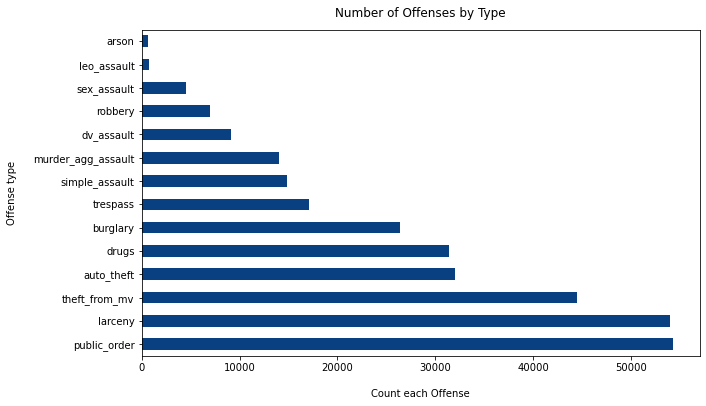

In [14]:
# Plotting number of offenses against count of offenses
working_data['offense_metric'].value_counts().plot(kind='barh', figsize=(10, 6), stacked = False, colormap = 'GnBu_r' )
plt.xlabel("Count each Offense", labelpad=16)
plt.ylabel("Offense type", labelpad=16)
plt.title("Number of Offenses by Type", y=1.02);

### Plotting Crimes by Month

In [15]:
# creating dataset for plotting specifically
plotting_data = working_data.drop(columns=['INCIDENT_ID', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_LON', 'GEO_LAT', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID'])
plotting_data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(plotting_data['FIRST_OCCURRENCE_DATE'])
plotting_data.head(5)

,FIRST_OCCURRENCE_DATE,offense_metric
20,2020-02-29 20:15:00,trespass
22,2016-06-07 20:00:00,trespass
38,2019-02-26 09:40:00,trespass
42,2017-05-13 18:20:00,trespass
54,2015-12-22 18:55:00,trespass


In [16]:
# Converting First Occurrence date to a year-month format
plotting_data['Year_Month'] = pd.to_datetime(plotting_data['FIRST_OCCURRENCE_DATE']).dt.to_period('M')
plotting_data.head(5)

,FIRST_OCCURRENCE_DATE,offense_metric,Year_Month
20,2020-02-29 20:15:00,trespass,2020-02
22,2016-06-07 20:00:00,trespass,2016-06
38,2019-02-26 09:40:00,trespass,2019-02
42,2017-05-13 18:20:00,trespass,2017-05
54,2015-12-22 18:55:00,trespass,2015-12


In [17]:
import matplotlib.dates as mdates
# Creating a new column in the dataframe that counts the number of each offense by year-month
plotting_data['Crime_Counts'] = plotting_data.groupby(['Year_Month', 'offense_metric'])['offense_metric'].transform('count')
plotting_data.head(5)

,FIRST_OCCURRENCE_DATE,offense_metric,Year_Month,Crime_Counts
20,2020-02-29 20:15:00,trespass,2020-02,368
22,2016-06-07 20:00:00,trespass,2016-06,228
38,2019-02-26 09:40:00,trespass,2019-02,250
42,2017-05-13 18:20:00,trespass,2017-05,291
54,2015-12-22 18:55:00,trespass,2015-12,193


In [18]:
# Converting the Year_Month column to a dataframe datetime format
plotting_data['Year_Month'] = plotting_data['Year_Month'].apply(lambda d: pd.to_datetime(str(d)))
plotting_data.head(5)

,FIRST_OCCURRENCE_DATE,offense_metric,Year_Month,Crime_Counts
20,2020-02-29 20:15:00,trespass,2020-02-01,368
22,2016-06-07 20:00:00,trespass,2016-06-01,228
38,2019-02-26 09:40:00,trespass,2019-02-01,250
42,2017-05-13 18:20:00,trespass,2017-05-01,291
54,2015-12-22 18:55:00,trespass,2015-12-01,193


In [19]:
# Checking datatypes for the plotting_data dataframe
plotting_data.dtypes

FIRST_OCCURRENCE_DATE    datetime64[ns]
offense_metric                   object
Year_Month               datetime64[ns]
Crime_Counts                      int64
dtype: object

In [20]:
# Import statements for interactive plot
%matplotlib inline
from ipywidgets import interactive
import pandas as pd
import numpy as np

# Sorting plotting_data in chronological order
plotting_data.sort_values(by = 'Year_Month', inplace = True)
plotting_data.head(5)

,FIRST_OCCURRENCE_DATE,offense_metric,Year_Month,Crime_Counts
425191,2015-01-26 15:50:00,larceny,2015-01-01,645
186889,2015-01-26 12:15:00,drugs,2015-01-01,483
72161,2015-01-06 12:00:00,auto_theft,2015-01-01,343
233262,2015-01-16 13:00:00,trespass,2015-01-01,204
105565,2015-01-24 00:58:00,public_order,2015-01-01,671


In [49]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Function that plots offense metric interactively by Year-Month and Count of the Offense
def multiplot(Offense):
    #opts = columns.values
    plotting_data.loc[plotting_data['offense_metric'] == Offense].plot.line(x='Year_Month', y='Crime_Counts', title = "Select Offense: Count of Offense by year", xlabel = 'Year', ylabel = 'Count of crime')
    #df.where[:, Offense].plot()

interactive_plot = interactive(multiplot, Offense = plotting_data['offense_metric'].unique())
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot



interactive(children=(Dropdown(description='Offense', options=('larceny', 'drugs', 'auto_theft', 'trespass', '…

### Mapping the locations of crime

In [22]:
# Plotting counts of crimes by month
graphing_data = working_data.drop(columns=['INCIDENT_ID', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID'])
graphing_data.head(5)

,GEO_LON,GEO_LAT,offense_metric
20,-104.988366,39.754698,trespass
22,-105.038484,39.763822,trespass
38,-105.000542,39.739501,trespass
42,-104.987600,39.765605,trespass
54,-104.988300,39.741702,trespass


In [23]:
# Taking a sample of the data to map! Sample will be .5% of the data to map what crime has looked like in the last 5 years in Denver
extraData, mapData = train_test_split(graphing_data, test_size = 0.0005)
mapData.count()
mapData = mapData.dropna()

In [24]:
# seperating out the data again by the official offense metric I created
trespass = mapData.loc[mapData['offense_metric'] == "trespass"]
murder_agg_assault = mapData.loc[mapData['offense_metric'] == "murder_agg_assault"]
public_order = mapData.loc[mapData['offense_metric'] == "public_order"]          
robbery = mapData.loc[mapData['offense_metric'] == "robbery"]
larceny = mapData.loc[mapData['offense_metric'] == "larceny"]                
sex_assault = mapData.loc[mapData['offense_metric'] == "sex_assault"]             
theft_from_mv = mapData.loc[mapData['offense_metric'] == "theft_from_mv"]           
arson = mapData.loc[mapData['offense_metric'] == "arson"]
auto_theft = mapData.loc[mapData['offense_metric'] == "auto_theft"]          
simple_assault = mapData.loc[mapData['offense_metric'] == "simple_assault"]
burglary = mapData.loc[mapData['offense_metric'] == "burglary"]              
leo_assault = mapData.loc[mapData['offense_metric'] == "leo_assault"]
drugs = mapData.loc[mapData['offense_metric'] == "drugs"]                 
dv_assault = mapData.loc[mapData['offense_metric'] == "dv_assault"]

In [25]:
# Look at counts of each crime for mapping purposes
print("trespass") 
print(trespass['offense_metric'].count())
print("murder_agg_assault") 
print(murder_agg_assault['offense_metric'].count())
print("public_order") 
print(public_order['offense_metric'].count())
print("robbery") 
print(robbery['offense_metric'].count())
print("larceny") 
print(larceny['offense_metric'].count())
print("sex_assault") 
print(sex_assault['offense_metric'].count())
print("theft_from_mv") 
print(theft_from_mv['offense_metric'].count())
print("arson") 
print(arson['offense_metric'].count())
print("auto_theft") 
print(auto_theft['offense_metric'].count())
print("simple_assault") 
print(simple_assault['offense_metric'].count())
print("burglary") 
print(burglary['offense_metric'].count())
print("leo_assault") 
print(leo_assault['offense_metric'].count())
print("drugs") 
print(drugs['offense_metric'].count())
print("dv_assault") 
print(dv_assault['offense_metric'].count())

trespass
9
murder_agg_assault
9
public_order
27
robbery
6
larceny
22
sex_assault
0
theft_from_mv
23
arson
1
auto_theft
20
simple_assault
4
burglary
9
leo_assault
1
drugs
20
dv_assault
3


#### My .5% sample shows that there were 0 arsons and 0 leo_assaults within that sample. The other 12 metrics will be plotted on the map

In [26]:
from folium.plugins import FastMarkerCluster, MarkerCluster

In [27]:
# Creating folium map
# Coordinates in middle of Denver city: 39.725461, -104.974278
denver_map = folium.Map(location=[39.725461, -104.974278])
# Add marker
#folium.LayerControl().add_to(denver_map)

# Creating Marker Clusters for the Layer Control of the map
ts = MarkerCluster(name="Trespass")
maa = MarkerCluster(name="Murder Agg Assault")
poc = MarkerCluster(name="Public Order Crimes")
rb = MarkerCluster(name="Robbery")
lc = MarkerCluster(name="Larceny")
sa = MarkerCluster(name="Sexual Assault")
tfm = MarkerCluster(name="Theft from Motor Vehicle")
at = MarkerCluster(name="Auto Theft")
sima = MarkerCluster(name="Simple Assault")
bg = MarkerCluster(name="Burglary")
dg = MarkerCluster(name="Drugs")
dva = MarkerCluster(name="Domestic Assault")

# Adding the data for each crime as a Marker Cluster
for index, row in trespass.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Trespass"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#007849",
                        popup=popup_text,
                        fill=False).add_to(ts)

for index, row in murder_agg_assault.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Murder Agg Assault"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#9479ee",
                        popup=popup_text,
                        fill=False).add_to(maa)
    
for index, row in public_order.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Public Order Crime"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#473838",
                        popup=popup_text,
                        fill=False).add_to(poc)
    
for index, row in robbery.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Robbery"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#4542f5",
                        popup=popup_text,
                        fill=False).add_to(rb)
    
for index, row in larceny.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Larceny"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#d90d32",
                        popup=popup_text,
                        fill=False).add_to(lc)

for index, row in sex_assault.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Sexual Assault"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#f08307",
                        popup=popup_text,
                        fill=False).add_to(sa)

for index, row in theft_from_mv.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Theft from Motor Vehicle"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#f7f014",
                        popup=popup_text,
                        fill=False).add_to(tfm)    

for index, row in auto_theft.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Auto Theft"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#9b14f5",
                        popup=popup_text,
                        fill=False).add_to(at)

for index, row in simple_assault.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Simple Assault"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#f707df",
                        popup=popup_text,
                        fill=False).add_to(sima)

for index, row in burglary.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Burglary"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#69f2f5",
                        popup=popup_text,
                        fill=False).add_to(bg)    
    
for index, row in drugs.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Drugs"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#b3afba",
                        popup=popup_text,
                        fill=False).add_to(dg)    

for index, row in dv_assault.iterrows():
    # generate the popup message that is shown on click.
    popup_text = "Domestic Assault"
    popup_text = popup_text.format(
                      index,
                      row['GEO_LAT'],
                      row['GEO_LON']
                      )
    folium.CircleMarker(location=(row['GEO_LAT'],
                                  row['GEO_LON']),
                        radius= 5,
                        color="#242326",
                        popup=popup_text,
                        fill=False).add_to(dva)

# Adding all the Marker Clusters to the map
ts.add_to(denver_map)
maa.add_to(denver_map)
poc.add_to(denver_map)
rb.add_to(denver_map)
lc.add_to(denver_map)
sa.add_to(denver_map)
tfm.add_to(denver_map)
at.add_to(denver_map)
sima.add_to(denver_map)
bg.add_to(denver_map)
dg.add_to(denver_map)
dva.add_to(denver_map)
# Adding the layer control to the map
folium.LayerControl().add_to(denver_map)
# Showing the map!
denver_map


### Prediction analysis using the Time Series Analysis AMIRA

#### I had orginally planned to create a much more indepth prediction analysis, but as I learned more about prediction models I realized I needed to tone my scope down for this project. I could not find a prediction model that would predict the likelihood of a crime based on historical counts of the crime and location. Instead I found the time series analysis AMIRA that takes historical data and can predict a total count of crime for a set time period. I have chosed to predict this based on neighorhood and by day.

In [28]:
# number of crimes by neighborhood
working_data['NEIGHBORHOOD_ID'].value_counts()

five-points      20301
cbd              13425
capitol-hill     12625
stapleton        11757
union-station     9476
                 ...  
skyland            972
central-park       728
country-club       711
indian-creek       460
wellshire          413
Name: NEIGHBORHOOD_ID, Length: 79, dtype: int64

#### Choosing the five-points neighborhood to run a predictive analysis on. Predicting the number of crimes by day

In [29]:
# Seperating the five points neighborhood data out
five_points = working_data.loc[working_data['NEIGHBORHOOD_ID'] == "five-points"]
five_points.head(5)

,INCIDENT_ID,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,offense_metric
20,2.020132e+09,criminal-trespassing,all-other-crimes,2/29/2020 20:15,2/29/2020 21:16,2222 LAWRENCE ST,-104.988366,39.754698,6,611,five-points,trespass
42,2.017312e+09,criminal-trespassing,all-other-crimes,5/13/2017 18:20,5/13/2017 18:57,1901 29TH ST,-104.987600,39.765605,6,612,five-points,trespass
293,2.016563e+09,criminal-trespassing,all-other-crimes,9/2/2016 18:00,9/2/2016 20:16,757 E 20TH AVE,-104.977538,39.748084,6,621,five-points,trespass
948,2.017579e+08,criminal-trespassing,all-other-crimes,1/26/2017 18:59,1/26/2017 22:09,2222 LAWERENCE ST,-104.988366,39.754698,6,611,five-points,trespass
1167,2.018496e+09,criminal-trespassing,all-other-crimes,7/22/2018 7:30,7/22/2018 8:06,2222 LAWRENCE ST,-104.988366,39.754698,6,611,five-points,trespass


In [30]:
# Dropping all unnecessary columns from the original data
five_points = five_points.drop(columns=['INCIDENT_ID', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID'])
five_points.head(5)

,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,GEO_LON,GEO_LAT,offense_metric
20,criminal-trespassing,all-other-crimes,2/29/2020 20:15,-104.988366,39.754698,trespass
42,criminal-trespassing,all-other-crimes,5/13/2017 18:20,-104.987600,39.765605,trespass
293,criminal-trespassing,all-other-crimes,9/2/2016 18:00,-104.977538,39.748084,trespass
948,criminal-trespassing,all-other-crimes,1/26/2017 18:59,-104.988366,39.754698,trespass
1167,criminal-trespassing,all-other-crimes,7/22/2018 7:30,-104.988366,39.754698,trespass


#### Transforming data to allow for analysis

In [31]:
# # Converting occurrence date to python date time format
five_points['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(five_points['FIRST_OCCURRENCE_DATE'])

In [32]:
# Adding a column to the data frame with just the date of the crime
five_points['Date'] = [d.date() for d in five_points['FIRST_OCCURRENCE_DATE']]
five_points.head(5)

,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,GEO_LON,GEO_LAT,offense_metric,Date
20,criminal-trespassing,all-other-crimes,2020-02-29 20:15:00,-104.988366,39.754698,trespass,2020-02-29
42,criminal-trespassing,all-other-crimes,2017-05-13 18:20:00,-104.987600,39.765605,trespass,2017-05-13
293,criminal-trespassing,all-other-crimes,2016-09-02 18:00:00,-104.977538,39.748084,trespass,2016-09-02
948,criminal-trespassing,all-other-crimes,2017-01-26 18:59:00,-104.988366,39.754698,trespass,2017-01-26
1167,criminal-trespassing,all-other-crimes,2018-07-22 07:30:00,-104.988366,39.754698,trespass,2018-07-22


In [33]:
# Removing all extra columns for the purposes of the predictive analysis
five_points_predict = five_points.drop(columns=['OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'GEO_LON', 'GEO_LAT', 'offense_metric'])
five_points_predict.head(5)

,Date
20,2020-02-29
42,2017-05-13
293,2016-09-02
948,2017-01-26
1167,2018-07-22


In [34]:
# Creating a count of date column. Showing a count of the crimes occurring on a particular day
five_points_predict['Counts'] = five_points.groupby(['Date'])['Date'].transform('count')
five_points_predict.head(5)

,Date,Counts
20,2020-02-29,10
42,2017-05-13,15
293,2016-09-02,12
948,2017-01-26,7
1167,2018-07-22,12


In [35]:
## Converting date to python date time format
five_points_predict['Date'] = pd.to_datetime(five_points_predict['Date'])
five_points_predict.head(5)

,Date,Counts
20,2020-02-29,10
42,2017-05-13,15
293,2016-09-02,12
948,2017-01-26,7
1167,2018-07-22,12


In [36]:
# Setting the index of the five points data
five_points_predict = five_points_predict.set_index('Date')
five_points_predict.index

DatetimeIndex(['2020-02-29', '2017-05-13', '2016-09-02', '2017-01-26',
               '2018-07-22', '2017-02-11', '2019-07-08', '2015-10-22',
               '2015-07-02', '2019-03-28',
               ...
               '2016-04-10', '2017-04-06', '2018-11-23', '2018-03-11',
               '2020-06-25', '2020-08-25', '2020-05-18', '2020-05-22',
               '2020-06-03', '2020-08-27'],
              dtype='datetime64[ns]', name='Date', length=20301, freq=None)

In [37]:
# creating a column with the mean values of the counts
y = five_points_predict['Counts'].resample('MS').mean()

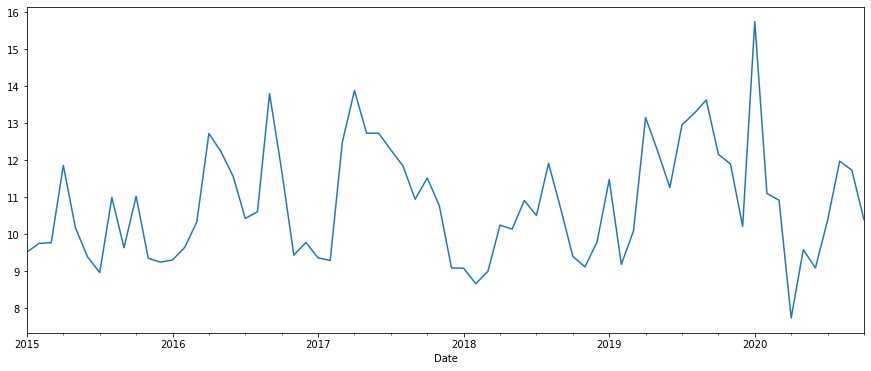

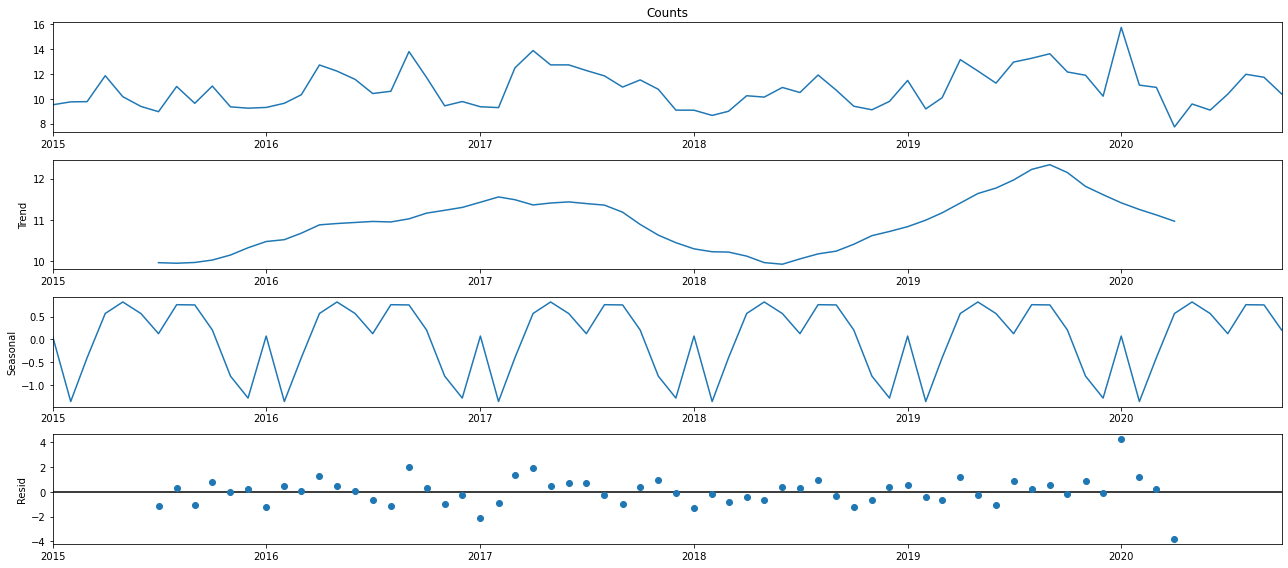

In [38]:
import statsmodels.api as sm
# Plotting the historical data
y['2017':]
y.plot(figsize=(15, 6))
plt.show()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [39]:
import itertools
# Setting p, d, and q data
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [40]:
# Setting the data in the ARIMA predictive model and printing the AIC data
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:528.0573319577232
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:392.47911160244905
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:243.57322963172547
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:185.1961121043262
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:248.80347193468694
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:233.21072840261476
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:187.6949074077813
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:184.80619738298375
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:448.04031225711293
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:333.4115134770624
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:227.58805889494772
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:174.13838398859
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:235.72546683923738
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:220.9908795119183
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:179.10984485919386
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:174.44103034099345
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:258.9075369382417
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:218.10205867836294
A

In [41]:
# Showing the fit of the model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5589      0.270      2.070      0.038       0.030       1.088
ma.L1         -1.0000   1.67e+04  -5.98e-05      1.000   -3.28e+04    3.28e+04
ar.S.L12      -0.5439      0.198     -2.747      0.006      -0.932      -0.156
sigma2         2.2846   3.82e+04   5.98e-05      1.000   -7.49e+04    7.49e+04


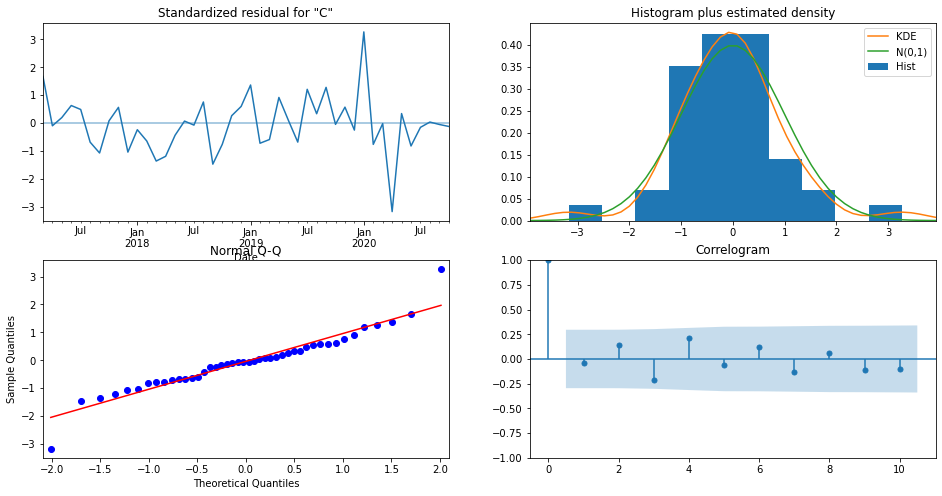

In [42]:
# Plotting the results of the model multiple ways
results.plot_diagnostics(figsize=(16, 8))
plt.show()

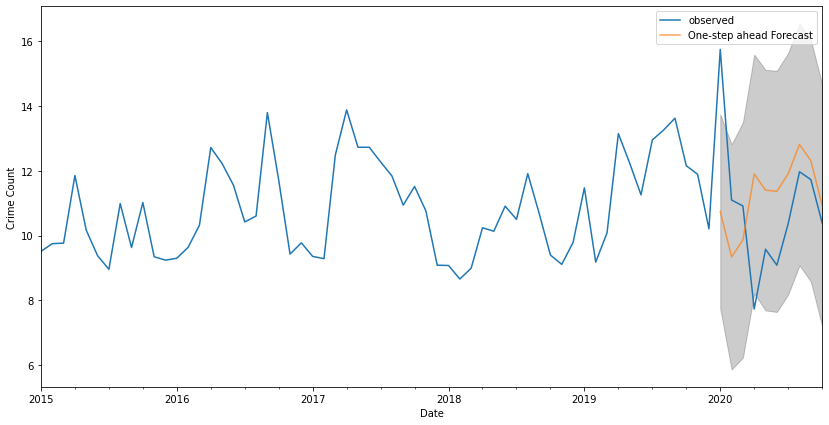

In [43]:
# Creating prediction results
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [44]:
# Calculating the mean squared error of the prediction model
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5.88


In [45]:
# Showing the root mean squared error for the forecast
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2.42


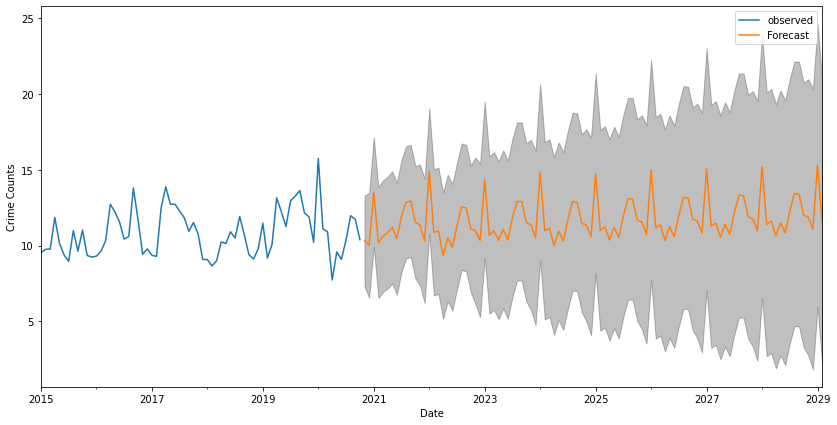

In [46]:
#Showing final prediction results the AMIRA model
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Counts')
plt.legend()
plt.show()

#### The prediction model here shows that it descends into a descernable pattern which will not be accurate in the long run, but this model can be updated and can learn from the differences between the prediction and the actual.